In [163]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os


DICTIONARIES_PATH = "../dictionary_learning/dictionaries"

In [164]:
def get_sparsity_penalty(config: dict, trainer_class: str) -> float:
    if trainer_class == "TrainerTopK":
        return config["trainer"]["k"]
    elif trainer_class == "PAnnealTrainer":
        return config["trainer"]["sparsity_penalty"]
    else:
        return config["trainer"]["l1_penalty"]


def ae_config_results(ae_paths: list[str], dictionaries_path: str) -> dict[str, dict[str, float]]:
    results = {}
    for ae_path in ae_paths:
        config_file = f"{ae_path}/config.json"

        with open(config_file, "r") as f:
            config = json.load(f)

        ae_name = ae_path.split(dictionaries_path)[1]

        results[ae_name] = {}

        trainer_class = config["trainer"]["trainer_class"]
        results[ae_name]["trainer_class"] = trainer_class
        results[ae_name]["l1_penalty"] = get_sparsity_penalty(config, trainer_class)

        results[ae_name]["lr"] = config["trainer"]["lr"]
        results[ae_name]["dict_size"] = config["trainer"]["dict_size"]
        if "steps" in config["trainer"]:
            results[ae_name]["steps"] = config["trainer"]["steps"]
        else:
            results[ae_name]["steps"] = -1

    return results


def add_custom_metric_results(
    ae_paths: list[str],
    results: dict[str, dict[str, float]],
    metric_filename: str,
    dictionaries_path: str,
    metric_dict_key: Optional[str] = None,
) -> dict[str, dict[str, float]]:
    for ae_path in ae_paths:
        config_file = f"{ae_path}/{metric_filename}"

        with open(config_file, "r") as f:
            custom_metric_results = json.load(f)

        ae_name = ae_path.split(dictionaries_path)[1]

        if metric_dict_key:
            results[ae_name]["custom_metric"] = custom_metric_results[metric_dict_key]
        else:
            for key, value in custom_metric_results.items():
                results[ae_name][key] = value

    return results


In [165]:
def filter_by_l0_threshold(results: dict, l0_threshold: Optional[int]) -> dict:
    if l0_threshold is not None:
        filtered_results = {
            path: data for path, data in results.items() if data["l0"] <= l0_threshold
        }

        # Optional: Print how many results were filtered out
        filtered_count = len(results) - len(filtered_results)
        print(f"Filtered out {filtered_count} results with L0 > {l0_threshold}")

        # Replace the original results with the filtered results
        results = filtered_results
    return results

In [166]:
# “Gated SAE”, “Gated SAE w/ p-annealing”, “Standard”, “Standard w/ p-annealing”
label_lookup = {
    "StandardTrainer": "Standard",
    # "PAnnealTrainer": "Standard w/ p-annealing",
    # "GatedSAETrainer": "Gated SAE",
    "TrainerJumpRelu": "JumpReLU",
    # "GatedAnnealTrainer": "Gated SAE w/ p-annealing",
    "TrainerTopK": "Top K",
    # "Identity": "Identity",
}

unique_trainers = list(label_lookup.keys())

# create a dictionary mapping trainer types to marker shapes

trainer_markers = {
    "StandardTrainer": "o",
    "TrainerJumpRelu": "X",
    "TrainerTopK": "^",
    "GatedSAETrainer": "d",
}


# default text size
plt.rcParams.update({"font.size": 20})

In [167]:
def plot_3var_graph(
    results: dict[str, dict[str, float]],
    title: str,
    custom_metric: str,
    xlims: Optional[tuple[float, float]] = None,
    ylims: Optional[tuple[float, float]] = None,
    colorbar_label: str = "Average Diff",
    output_filename: Optional[str] = None,
    legend_location: str = "lower right",
    x_axis_key: str = "l0",
    y_axis_key: str = "frac_recovered",
):
    # Extract data from results
    l0_values = [data[x_axis_key] for data in results.values()]
    frac_recovered_values = [data[y_axis_key] for data in results.values()]
    average_diff_values = [data[custom_metric] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a normalize object for color scaling
    norm = Normalize(vmin=min(average_diff_values), vmax=max(average_diff_values))

    handles, labels = [], []

    for trainer, marker in trainer_markers.items():
        # Filter data for this trainer
        trainer_data = {k: v for k, v in results.items() if v["trainer_class"] == trainer}

        if not trainer_data:
            continue  # Skip this trainer if no data points

        l0_values = [data[x_axis_key] for data in trainer_data.values()]
        frac_recovered_values = [data[y_axis_key] for data in trainer_data.values()]
        average_diff_values = [data[custom_metric] for data in trainer_data.values()]

        # Plot data points
        scatter = ax.scatter(
            l0_values,
            frac_recovered_values,
            c=average_diff_values,
            cmap="viridis",
            marker=marker,
            s=100,
            label=label_lookup[trainer],
            norm=norm,
            edgecolor="black",
        )

        # custom legend stuff
        _handle, _ = scatter.legend_elements(prop="sizes")
        _handle[0].set_markeredgecolor("black")
        _handle[0].set_markerfacecolor("white")
        _handle[0].set_markersize(10)
        if marker == "d":
            _handle[0].set_markersize(13)
        handles += _handle
        labels.append(label_lookup[trainer])

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, label=colorbar_label)

    # Set labels and title
    ax.set_xlabel("L0 (Sparsity)")
    ax.set_ylabel("Loss Recovered (Fidelity)")
    ax.set_title(title)

    ax.legend(handles, labels, loc=legend_location)

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if ylims:
        ax.set_ylim(*ylims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()


# print(results)
# if include_diff:
# plot_3var_graph(results)


In [168]:
import plotly.graph_objects as go
from typing import Optional, Dict, Any


def plot_interactive_3var_graph(
    results: dict[str, dict[str, float]],
    custom_color_metric: str,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
    x_axis_key: str = "l0",
    y_axis_key: str = "frac_recovered",
):
    # Extract data from results
    ae_paths = list(results.keys())
    l0_values = [data[x_axis_key] for data in results.values()]
    frac_recovered_values = [data[y_axis_key] for data in results.values()]

    custom_metric_value = [data[custom_color_metric] for data in results.values()]

    dict_size = [data["dict_size"] for data in results.values()]
    lr = [data["lr"] for data in results.values()]
    l1_penalty = [data["l1_penalty"] for data in results.values()]

    # Create the scatter plot
    fig = go.Figure()

    # Add trace
    fig.add_trace(
        go.Scatter(
            x=l0_values,
            y=frac_recovered_values,
            mode="markers",
            marker=dict(
                size=10,
                color=custom_metric_value,  # Color points based on frac_recovered
                colorscale="Viridis",  # You can change this colorscale
                showscale=True,
            ),
            text=[
                f"AE Path: {ae}<br>L0: {l0:.4f}<br>Frac Recovered: {fr:.4f}<br>Custom Metric: {ad:.4f}<br>Dict Size: {d:.4f}<br>LR: {l:.4f}<br>L1 Penalty: {l1:.4f}"
                for ae, l0, fr, ad, d, l, l1 in zip(
                    ae_paths,
                    l0_values,
                    frac_recovered_values,
                    custom_metric_value,
                    dict_size,
                    lr,
                    l1_penalty,
                )
            ],
            hoverinfo="text",
        )
    )

    # Update layout
    fig.update_layout(
        title="L0 vs Loss Recovered",
        xaxis_title="L0 (Sparsity)",
        yaxis_title="Loss Recovered (Fidelity)",
        hovermode="closest",
    )

    # Set axis limits
    if xlims:
        fig.update_xaxes(range=xlims)
    if y_lims:
        fig.update_yaxes(range=y_lims)

    # Save and show the plot
    if output_filename:
        fig.write_html(output_filename)

    fig.show()


# Example usage:
# plot_interactive_3var_graph(results)

In [169]:
def plot_2var_graph(
    results: dict[str, dict[str, float]],
    custom_metric: str,
    title: str = "L0 vs Custom Metric",
    y_label: str = "Custom Metric",
    xlims: Optional[tuple[float, float]] = None,
    ylims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
    legend_location: str = "lower right",
    original_acc: Optional[float] = None,
    x_axis_key: str = "l0",
):
    # Extract data from results
    l0_values = [data[x_axis_key] for data in results.values()]
    custom_metric_values = [data[custom_metric] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    handles, labels = [], []

    for trainer, marker in trainer_markers.items():
        # Filter data for this trainer
        trainer_data = {k: v for k, v in results.items() if v["trainer_class"] == trainer}

        if not trainer_data:
            continue  # Skip this trainer if no data points

        l0_values = [data[x_axis_key] for data in trainer_data.values()]
        custom_metric_values = [data[custom_metric] for data in trainer_data.values()]

        # Plot data points
        scatter = ax.scatter(
            l0_values,
            custom_metric_values,
            marker=marker,
            s=100,
            label=label_lookup[trainer],
            edgecolor="black",
        )

        # custom legend stuff
        _handle, _ = scatter.legend_elements(prop="sizes")
        _handle[0].set_markeredgecolor("black")
        _handle[0].set_markerfacecolor("white")
        _handle[0].set_markersize(10)
        if marker == "d":
            _handle[0].set_markersize(13)
        handles += _handle
        labels.append(label_lookup[trainer])

    # Set labels and title
    ax.set_xlabel("L0 (Sparsity)")
    ax.set_ylabel(y_label)
    ax.set_title(title)

    if original_acc:
        ax.axhline(original_acc, color="red", linestyle="--", label="Original Probe Accuracy")

    ax.legend(handles, labels, loc=legend_location)

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if ylims:
        ax.set_ylim(*ylims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()


In [170]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from collections import defaultdict


def plot_steps_vs_average_diff(
    results_dict: dict,
    steps_key: str = "steps",
    avg_diff_key: str = "average_diff",
    title: Optional[str] = None,
    y_label: Optional[str] = None,
    output_filename: Optional[str] = None,
):
    # Initialize a defaultdict to store data for each trainer
    trainer_data = defaultdict(lambda: {"steps": [], "average_diffs": []})

    all_steps = set()

    # Extract data from the dictionary
    for key, value in results_dict.items():
        # Extract trainer number from the key
        trainer = key.split("/")[-1].split("_")[1]  # Assuming format like "trainer_1_..."
        layer = key.split("/")[-2].split("_")[-2]

        if "topk_ctx128" in key:
            trainer_type = "TopK SAE"
        elif "standard_ctx128" in key:
            trainer_type = "Standard SAE"
        else:
            raise ValueError(f"Unknown trainer type in key: {key}")

        step = int(value[steps_key])
        avg_diff = value[avg_diff_key]

        trainer_key = f"{trainer_type} Layer {layer} Trainer {trainer}"

        trainer_data[trainer_key]["steps"].append(step)
        trainer_data[trainer_key]["average_diffs"].append(avg_diff)
        all_steps.add(step)

    # Calculate average across all trainers
    average_trainer_data = {"steps": [], "average_diffs": []}
    for step in sorted(all_steps):
        step_diffs = []
        for data in trainer_data.values():
            if step in data["steps"]:
                idx = data["steps"].index(step)
                step_diffs.append(data["average_diffs"][idx])
        if step_diffs:
            average_trainer_data["steps"].append(step)
            average_trainer_data["average_diffs"].append(np.mean(step_diffs))

    # Add average_trainer_data to trainer_data
    trainer_data["Average"] = average_trainer_data

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot data for each trainer
    for trainer_key, data in trainer_data.items():
        steps = data["steps"]
        average_diffs = data["average_diffs"]

        # Sort the data by steps to ensure proper ordering
        sorted_data = sorted(zip(steps, average_diffs))
        steps, average_diffs = zip(*sorted_data)

        # Find the maximum step value for this trainer
        max_step = max(steps)

        # Convert steps to percentages of max_step
        step_percentages = [step / max_step * 100 for step in steps]

        # Plot the line for this trainer
        if trainer_key == "Average":
            plt.plot(
                step_percentages,
                average_diffs,
                marker="o",
                label=trainer_key,
                linewidth=3,
                color="red",
                zorder=10,
            )  # Emphasized average line
        else:
            plt.plot(
                step_percentages,
                average_diffs,
                marker="o",
                label=trainer_key,
                alpha=0.3,
                linewidth=1,
            )  # More transparent individual lines

    # log scale
    # plt.xscale("log")

    # if not title:
    #     title = f'{steps_key.capitalize()} vs {avg_diff_key.replace("_", " ").capitalize()}'

    if not y_label:
        y_label = avg_diff_key.replace("_", " ").capitalize()

    plt.xlabel("Training Progess (%)")
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)  # More transparent grid

    if len(trainer_data) < 50 and False:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")

    # Show the plot
    plt.show()

In [171]:
def get_nested_folders(path: str) -> list[str]:
    """
    Recursively get a list of folders that contain an ae.pt file, starting the search from the given path
    """
    folder_names = []

    # We use config.json so it also works for data folders
    for root, dirs, files in os.walk(path):
        if "config.json" in files:
            folder_names.append(root)

    return folder_names


def check_for_empty_folders(ae_group_paths: list[str]) -> bool:
    """So your run doesn't crash / do nothing interesting because folder 13 is empty."""
    for ae_group_path in ae_group_paths:
        if len(get_nested_folders(ae_group_path)) == 0:
            raise ValueError(f"No folders found in {ae_group_path}")
    return True


def get_ae_group_paths(
    dictionaries_path: str, sweep_name: str, submodule_trainers: Optional[dict]
) -> list[str]:
    if submodule_trainers is None:
        return [f"{dictionaries_path}/{sweep_name}"]

    ae_group_paths = []

    for submodule in submodule_trainers.keys():
        trainer_ids = submodule_trainers[submodule]["trainer_ids"]

        base_filename = f"{dictionaries_path}/{sweep_name}/{submodule}"

        if trainer_ids is None:
            ae_group_paths.append(base_filename)
        else:
            for trainer_id in trainer_ids:
                ae_group_paths.append(f"{base_filename}/trainer_{trainer_id}")

    check_for_empty_folders(ae_group_paths)

    return ae_group_paths


def get_ae_paths(ae_group_paths: list[str]) -> list[str]:
    ae_paths = []
    for ae_group_path in ae_group_paths:
        ae_paths.extend(get_nested_folders(ae_group_path))
    return ae_paths


The following cell can be used to load autoencoders from the nested folder structure.

In [172]:
# from dictionary_learning import AutoEncoder, ActivationBuffer
# from dictionary_learning.dictionary import (
#     IdentityDict,
#     GatedAutoEncoder,
#     AutoEncoderNew,
#     JumpReluAutoEncoder,
# )
# from dictionary_learning.trainers.top_k import AutoEncoderTopK

# def load_dictionary(model, base_path: str, device: str, verbose: bool = True):
#     if verbose:
#         print(f"Loading dictionary from {base_path}")
#     ae_path = f"{base_path}/ae.pt"
#     config_path = f"{base_path}/config.json"

#     with open(config_path, "r") as f:
#         config = json.load(f)

#     submodule_str = config["trainer"]["submodule_name"]
#     layer = config["trainer"]["layer"]
#     model_name = config["trainer"]["lm_name"]
#     dict_class = config["trainer"]["dict_class"]

#     first_model_name = model.config._name_or_path
#     assert type(first_model_name) == str, "Model name must be a string"

#     assert (
#         model_name == first_model_name
#     ), f"Model name {model_name} does not match first model name {first_model_name}"

#     submodule = get_submodule(model, submodule_str, layer)

#     if dict_class == "AutoEncoder":
#         dictionary = AutoEncoder.from_pretrained(ae_path, device=device)
#     # elif dict_class == "IdentityDict":
#     #     dictionary = IdentityDict.from_pretrained(ae_path, device=device)
#     elif dict_class == "GatedAutoEncoder":
#         dictionary = GatedAutoEncoder.from_pretrained(ae_path, device=device)
#     elif dict_class == "AutoEncoderNew":
#         dictionary = AutoEncoderNew.from_pretrained(ae_path, device=device)
#     elif dict_class == "AutoEncoderTopK":
#         k = config["trainer"]["k"]
#         dictionary = AutoEncoderTopK.from_pretrained(ae_path, k=k, device=device)
#     elif dict_class == "JumpReluAutoEncoder":
#         dictionary = JumpReluAutoEncoder.from_pretrained(ae_path, device=device)
#     else:
#         raise ValueError(f"Dictionary class {dict_class} not supported")

#     return submodule, dictionary, config


# def get_submodule(model, submodule_str: str, layer: int):
#     allowed_submodules = ["attention_out", "mlp_out", "resid_post", "unembed"]

#     model_architecture = model.config.architectures[0]

#     assert type(model_architecture) == str, "Model architecture must be a string"

#     if model_architecture == "GPTNeoXForCausalLM":
#         if "attention_out" in submodule_str:
#             submodule = model.gpt_neox.layers[layer].attention
#         elif "mlp_out" in submodule_str:
#             submodule = model.gpt_neox.layers[layer].mlp
#         elif "resid_post" in submodule_str:
#             submodule = model.gpt_neox.layers[layer]
#         elif "unembed" in submodule_str:
#             submodule = model.embed_out
#         else:
#             raise ValueError(f"submodule_str must contain one of {allowed_submodules}")
#     elif model_architecture == "Gemma2ForCausalLM":
#         if "resid_post" in submodule_str:
#             submodule = model.model.layers[layer]
#         elif "unembed" in submodule_str:
#             submodule = model.lm_head
#         else:
#             raise ValueError(f"submodule_str must contain one of {allowed_submodules}")
#     else:
#         raise ValueError(f"Model architecture {model_architecture} not supported")

#     return submodule

In [173]:
image_filename_prefix = "images/"

if not os.path.exists("images"):
    os.makedirs("images")

This cell is an optional way to create `plotting_results` from Can / Adam's nested folder structure.

In [174]:
# # If trainer_ids is None, all trainers will be plotted
# trainer_ids = None

# # To only graph e.g. trainer_ids 1 and 2, set trainer_ids = [1, 2]
# # To graph all layers at once, do something like this:

# # ae_sweep_paths = {
# #     "gemma-2-2b_sweep_standard_ctx128_ef8_0824": None,
# # }


# ae_sweep_paths = {
#     "pythia70m_sweep_standard_ctx128_0712": None,
#     "pythia70m_sweep_topk_ctx128_0730": None,
# }

# DICTIONARIES_PATH = (
#     "../dictionary_learning/dictionaries/09_23_pythia_tpp_autointerp"
# )

# plot_spurious = False
# plot_tpp = True
# plot_checkpoints = False
# plot_averaged_results = False

# l0_threshold = 500

# model = "Pythia-70M"

# l0_threshold = None

# no_title = True


# ae_paths = []

# for sweep_name, submodule_trainers in ae_sweep_paths.items():
#     ae_group_paths = get_ae_group_paths(DICTIONARIES_PATH, sweep_name, submodule_trainers)
#     ae_paths.extend(get_ae_paths(ae_group_paths))


# plotting_results = ae_config_results(ae_paths, DICTIONARIES_PATH + "/")
# plotting_results = add_custom_metric_results(
#     ae_paths, plotting_results, "eval_results.json", DICTIONARIES_PATH + "/"
# )
# print(plotting_results.keys())

Examples of how to update `plotting_results`

In [175]:
# plotting_results = add_custom_metric_results(
#     ae_paths, plotting_results, "tpp_results.json", DICTIONARIES_PATH + "/", metric_dict_key=None
# )

# print(plotting_results.keys())

# first_key = next(iter(plotting_results.keys()))
# print(plotting_results[first_key].keys())

# scr_filename = "all_Pythia-70M_scr_results.json"

# with open(scr_filename, "r") as f:
#     scr_results = json.load(f)

# for ae_name in scr_results.keys():
#     assert ae_name in plotting_results, f"{ae_name} not found in plotting_results"
#     plotting_results[ae_name].update(scr_results[ae_name])

In [176]:
model_name = "gemma"

if model_name == "gemma":
    dir = 2
elif model_name == "pythia":
    dir = 1
else:
    raise ValueError(f"Model name {model_name} not supported")

results_filename = f"all_scr_tpp_{model_name}_results.json"

with open(results_filename, "r") as f:
    plotting_results = json.load(f)

threshold = 50

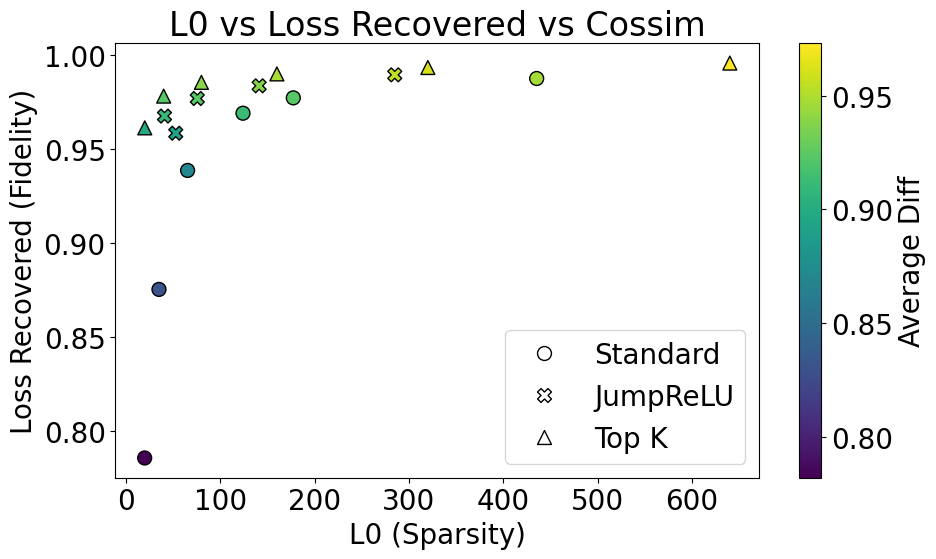

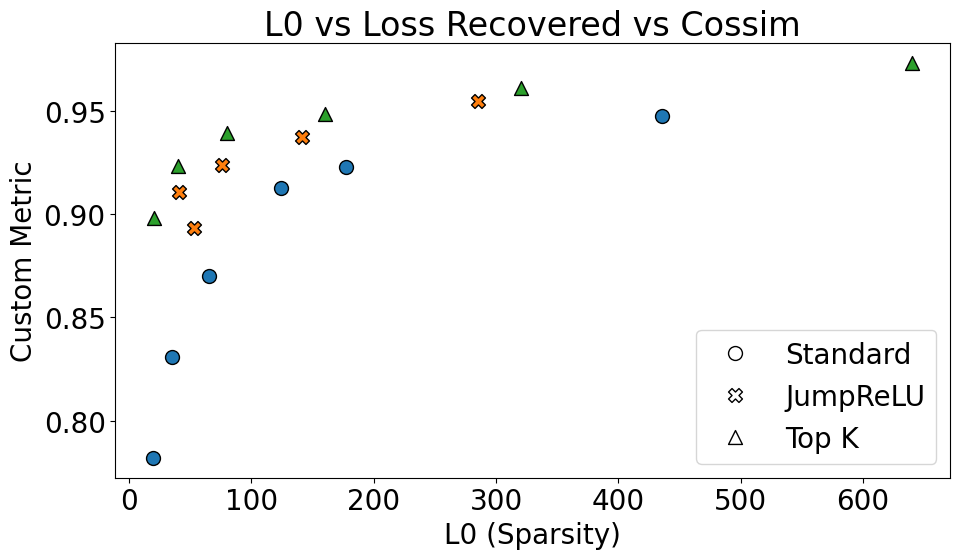

In [177]:
# plotting_results = filter_by_l0_threshold(plotting_results, l0_threshold)

custom_metric = "l1_penalty"
custom_metric = "cossim"

title = f"L0 vs Loss Recovered vs {custom_metric.replace('_', ' ').capitalize()}"

plot_3var_graph(
    plotting_results,
    title,
    custom_metric,
    output_filename=f"{image_filename_prefix}{custom_metric}_3var.png",
)
plot_2var_graph(
    plotting_results,
    custom_metric,
    title=title,
    output_filename=f"{image_filename_prefix}{custom_metric}_2var.png",
)
plot_interactive_3var_graph(plotting_results, custom_metric)

# At this point, if there's any additional .json files located alongside the ae.pt and eval_results.json
# You can easily adapt them to be included in the plotting_results dictionary by using something similar to add_ae_config_results()

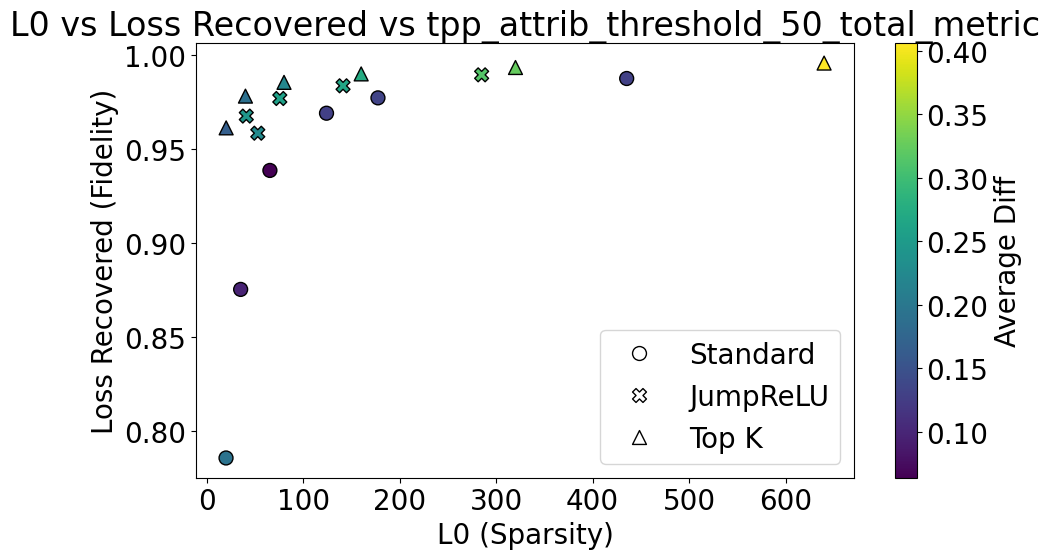

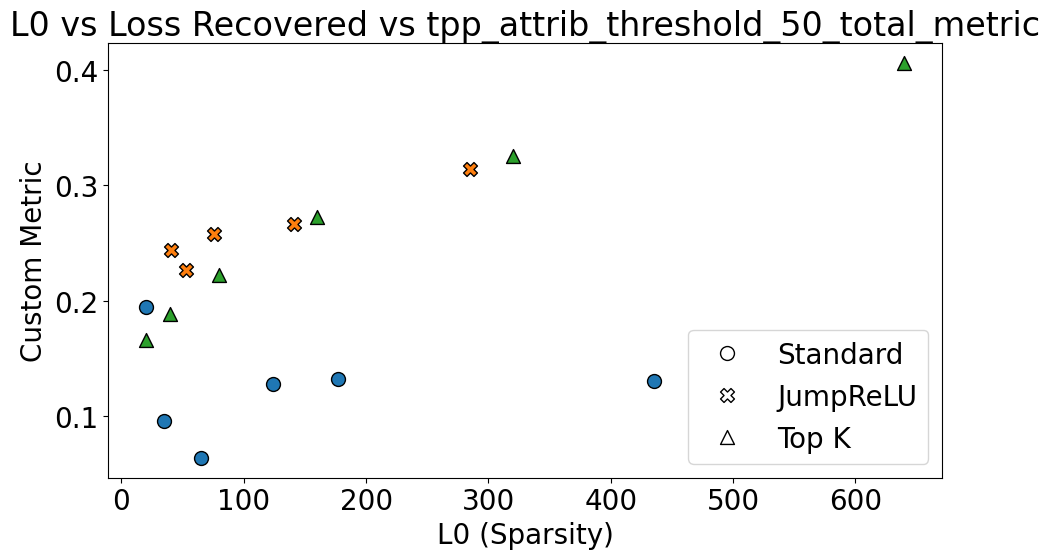

In [178]:
custom_metric = f"tpp_auto_interp_threshold_{threshold}_total_metric"
custom_metric = f"tpp_attrib_threshold_{threshold}_total_metric"

title = f"L0 vs Loss Recovered vs {custom_metric}"

plot_3var_graph(
    plotting_results,
    title,
    custom_metric,
    output_filename=f"{image_filename_prefix}{custom_metric}_3var.png",
)
plot_2var_graph(
    plotting_results,
    custom_metric,
    title=title,
    y_label="Custom Metric",
    output_filename=f"{image_filename_prefix}{custom_metric}_2var.png",
)
plot_interactive_3var_graph(plotting_results, custom_metric)

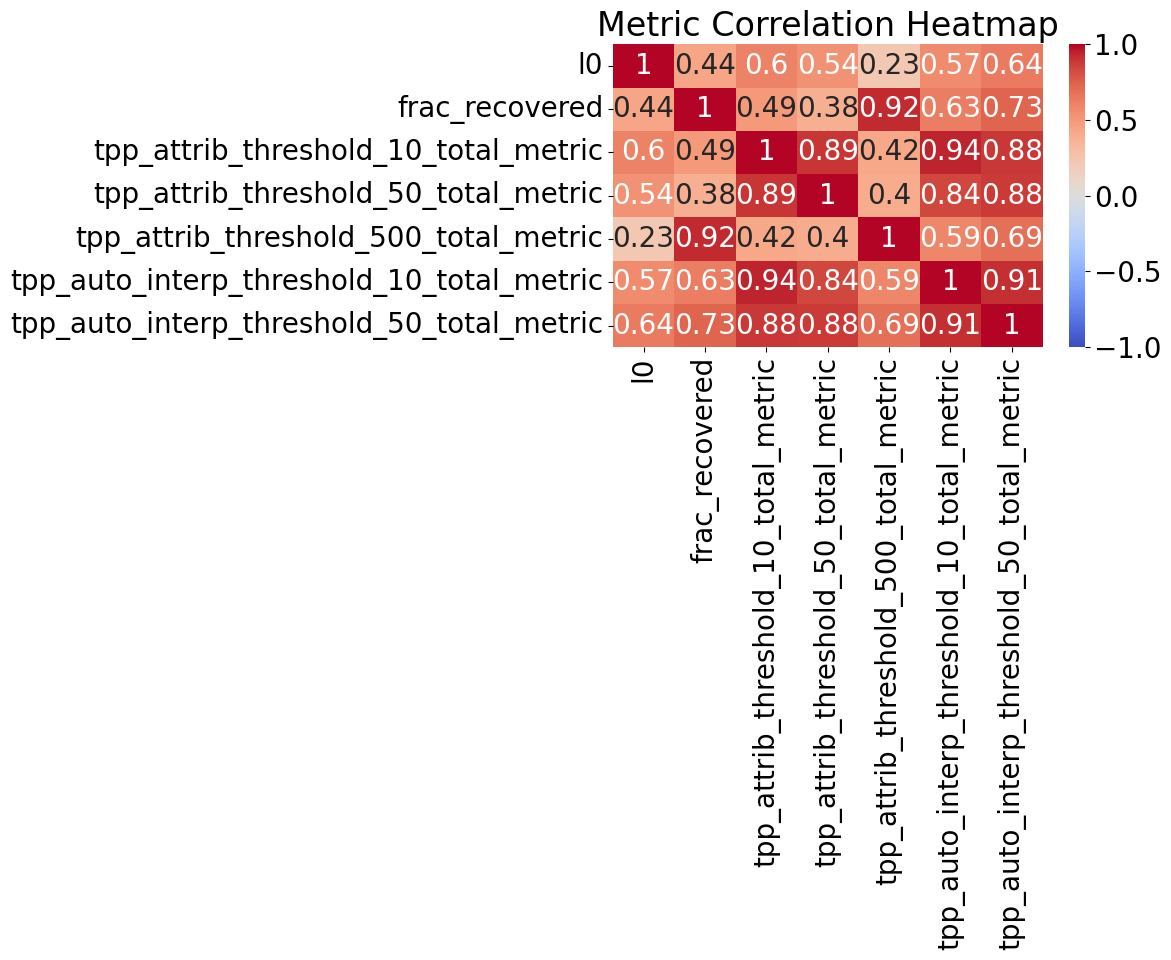

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_correlation_heatmap(
    plotting_results: dict[str, dict[str, float]],
    metric_names: list[str],
    ae_names: Optional[list[str]] = None,
    title: str = "Metric Correlation Heatmap",
    output_filename: str = None,
    figsize: tuple = (12, 10),
    cmap: str = "coolwarm",
    annot: bool = True,
):
    # If ae_names is not provided, use all ae_names from plotting_results
    if ae_names is None:
        ae_names = list(plotting_results.keys())

    # If metric_names is not provided, use all metric names from the first ae_name
    # if metric_names is None:
    #     metric_names = list(plotting_results[ae_names[0]].keys())

    # Create a DataFrame from the plotting_results
    data = []
    for ae in ae_names:
        row = [plotting_results[ae].get(metric, np.nan) for metric in metric_names]
        data.append(row)

    df = pd.DataFrame(data, index=ae_names, columns=metric_names)

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, vmin=-1, vmax=1, center=0)

    plt.title(title)
    plt.tight_layout()

    # Save the plot if output_filename is provided
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")

    plt.show()


metric_keys = [
    "l0",
    "frac_recovered",
    "tpp_attrib_threshold_10_total_metric",
    "tpp_attrib_threshold_50_total_metric",
    "tpp_attrib_threshold_500_total_metric",
    "tpp_auto_interp_threshold_10_total_metric",
    "tpp_auto_interp_threshold_50_total_metric",
]

plot_correlation_heatmap(plotting_results, metric_names=metric_keys, ae_names=None)

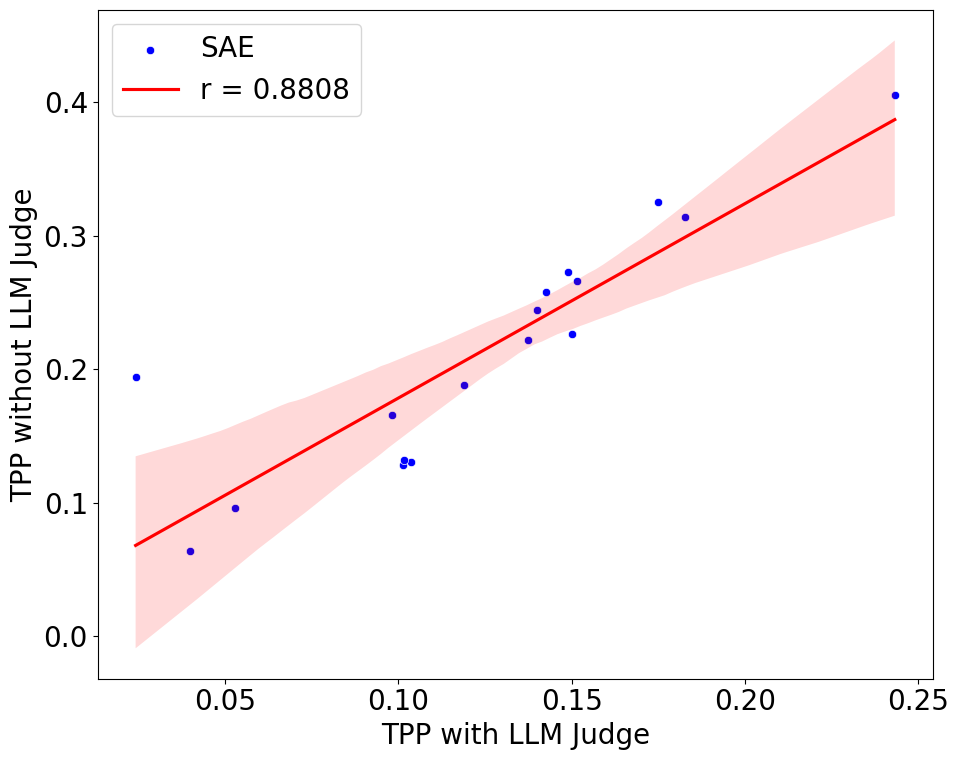

Pearson correlation coefficient (r): 0.8808
Coefficient of determination (r²): 0.7758
P-value: 0.0000


In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from typing import Optional


def plot_metric_scatter(
    plotting_results: dict[str, dict[str, float]],
    metric_x: str,
    metric_y: str,
    x_label: Optional[str] = None,
    y_label: Optional[str] = None,
    ae_names: Optional[list[str]] = None,
    title: str = "Metric Comparison Scatter Plot",
    output_filename: Optional[str] = None,
    figsize: tuple = (10, 8),
):
    # If ae_names is not provided, use all ae_names from plotting_results
    if ae_names is None:
        ae_names = list(plotting_results.keys())

    # Extract x and y values for the specified metrics
    x_values = [plotting_results[ae].get(metric_x, float("nan")) for ae in ae_names]
    y_values = [plotting_results[ae].get(metric_y, float("nan")) for ae in ae_names]

    # Remove any NaN values
    valid_data = [
        (x, y, ae)
        for x, y, ae in zip(x_values, y_values, ae_names)
        if not (np.isnan(x) or np.isnan(y))
    ]
    if not valid_data:
        print("No valid data points after removing NaN values.")
        return

    x_values, y_values, valid_ae_names = zip(*valid_data)

    # Convert to numpy arrays
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Calculate correlation coefficients
    r, p_value = stats.pearsonr(x_values, y_values)
    r_squared = r**2

    # Create the scatter plot
    plt.figure(figsize=figsize)
    scatter = sns.scatterplot(x=x_values, y=y_values, label="SAE", color="blue")

    if x_label is None:
        x_label = metric_x
    if y_label is None:
        y_label = metric_y

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add a trend line
    sns.regplot(x=x_values, y=y_values, scatter=False, color="red", label=f"r = {r:.4f}")

    plt.legend()

    plt.tight_layout()

    # Save the plot if output_filename is provided
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")

    plt.show()

    # Print correlation coefficients
    print(f"Pearson correlation coefficient (r): {r:.4f}")
    print(f"Coefficient of determination (r²): {r_squared:.4f}")
    print(f"P-value: {p_value:.4f}")


# Example usage:
# plot_metric_scatter(plotting_results, metric_x="l0", metric_y="frac_recovered", title="L0 vs Fraction Recovered")

metric1 = f"tpp_auto_interp_threshold_{threshold}_total_metric"
metric2 = f"tpp_attrib_threshold_{threshold}_total_metric"
title = f""

x_label = "TPP with LLM Judge"
y_label = "TPP without LLM Judge"
output_filename = f"{image_filename_prefix}tpp_comparison_{threshold}_{model_name}.png"

plot_metric_scatter(
    plotting_results,
    metric_x=metric1,
    metric_y=metric2,
    title=title,
    x_label=x_label,
    y_label=y_label,
    output_filename=output_filename,
)


dict_keys(['trainer_class', 'l1_penalty', 'lr', 'dict_size', 'steps', 'l2_loss', 'l1_loss', 'l0', 'frac_variance_explained', 'cossim', 'l2_ratio', 'relative_reconstruction_bias', 'loss_original', 'loss_reconstructed', 'loss_zero', 'frac_recovered', 'frac_alive', 'hyperparameters', 'tpp_attrib_threshold_2_total_metric', 'tpp_attrib_threshold_2_intended_diff_only', 'tpp_attrib_threshold_2_unintended_diff_only', 'tpp_attrib_threshold_5_total_metric', 'tpp_attrib_threshold_5_intended_diff_only', 'tpp_attrib_threshold_5_unintended_diff_only', 'tpp_attrib_threshold_10_total_metric', 'tpp_attrib_threshold_10_intended_diff_only', 'tpp_attrib_threshold_10_unintended_diff_only', 'tpp_attrib_threshold_20_total_metric', 'tpp_attrib_threshold_20_intended_diff_only', 'tpp_attrib_threshold_20_unintended_diff_only', 'tpp_attrib_threshold_50_total_metric', 'tpp_attrib_threshold_50_intended_diff_only', 'tpp_attrib_threshold_50_unintended_diff_only', 'tpp_attrib_threshold_100_total_metric', 'tpp_attrib_t

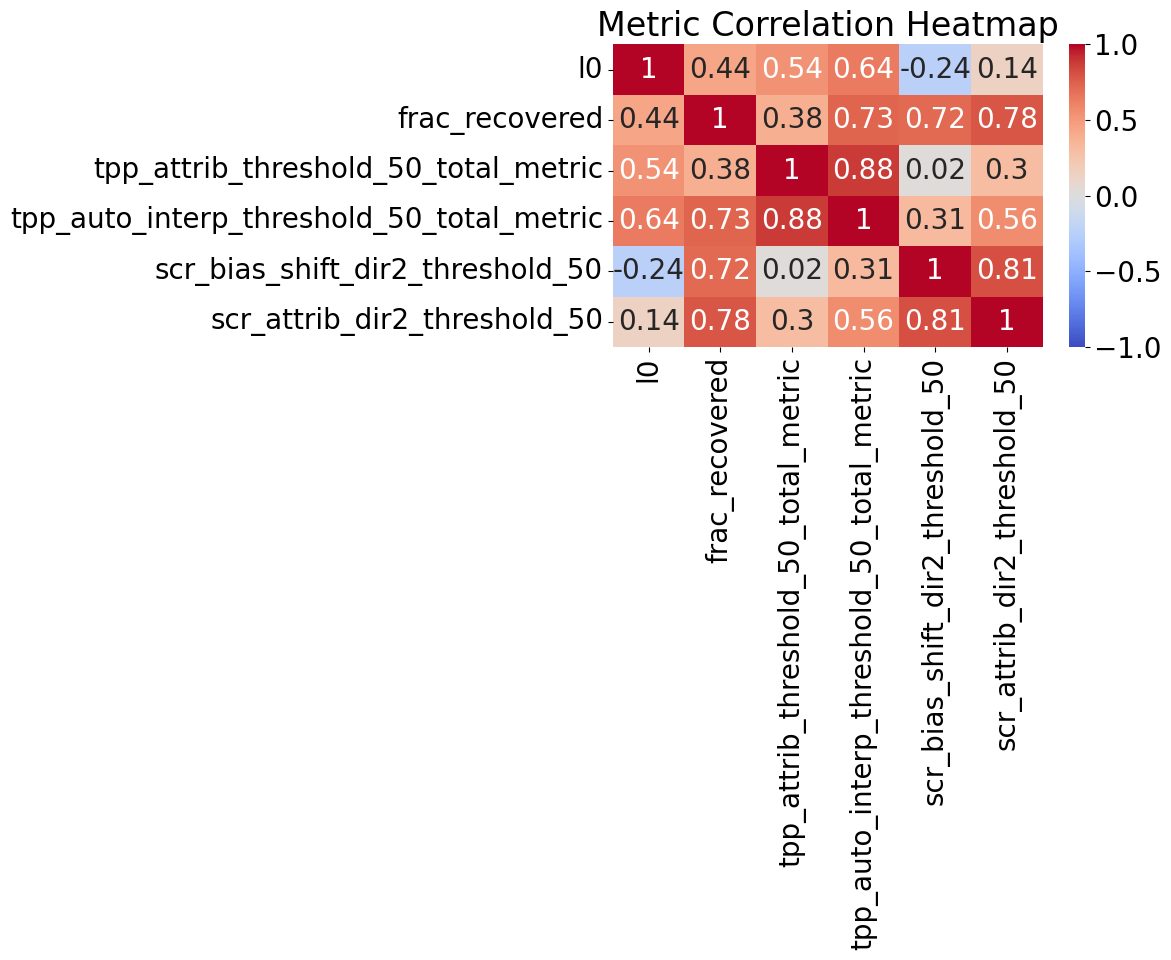

In [181]:
first_key = next(iter(plotting_results.keys()))
print(plotting_results[first_key].keys())

metric_keys = [
    "l0",
    "frac_recovered",
    "tpp_attrib_threshold_20_total_metric",
    "tpp_attrib_threshold_50_total_metric",
    "tpp_attrib_threshold_500_total_metric",
    "tpp_auto_interp_threshold_20_total_metric",
    "tpp_auto_interp_threshold_50_total_metric",
    "scr_bias_shift_dir2_threshold_20",
    "scr_bias_shift_dir2_threshold_50",
    "scr_bias_shift_dir1_threshold_20",
    "scr_bias_shift_dir1_threshold_50",
    "scr_attrib_dir2_threshold_20",
    "scr_attrib_dir2_threshold_50",
    "scr_attrib_dir1_threshold_20",
    "scr_attrib_dir1_threshold_50",
]

metric_keys = [
    "l0",
    "frac_recovered",
    "tpp_attrib_threshold_50_total_metric",
    "tpp_auto_interp_threshold_50_total_metric",
    "scr_bias_shift_dir2_threshold_50",
    # "scr_bias_shift_dir1_threshold_50",
    "scr_attrib_dir2_threshold_50",
    # "scr_attrib_dir1_threshold_50",
]

plot_correlation_heatmap(plotting_results, metric_names=metric_keys, ae_names=None, annot=True)

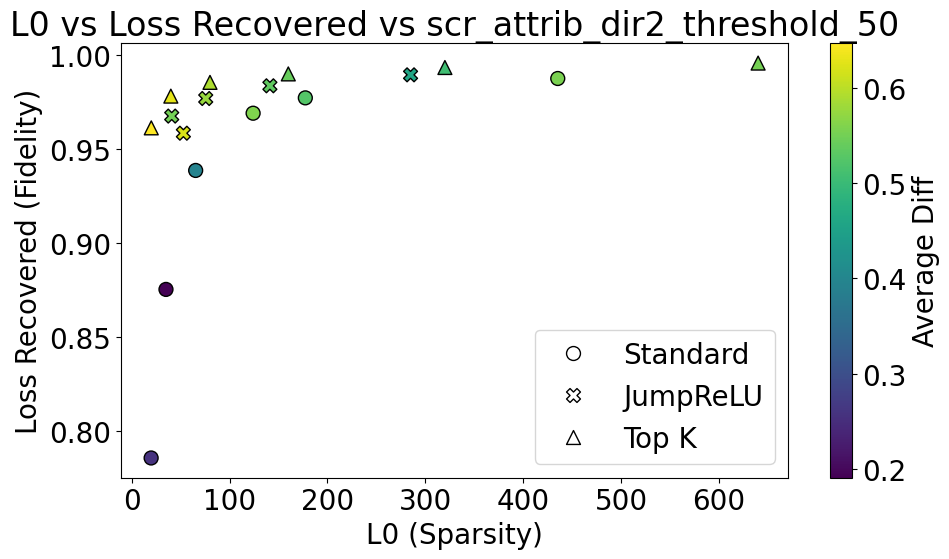

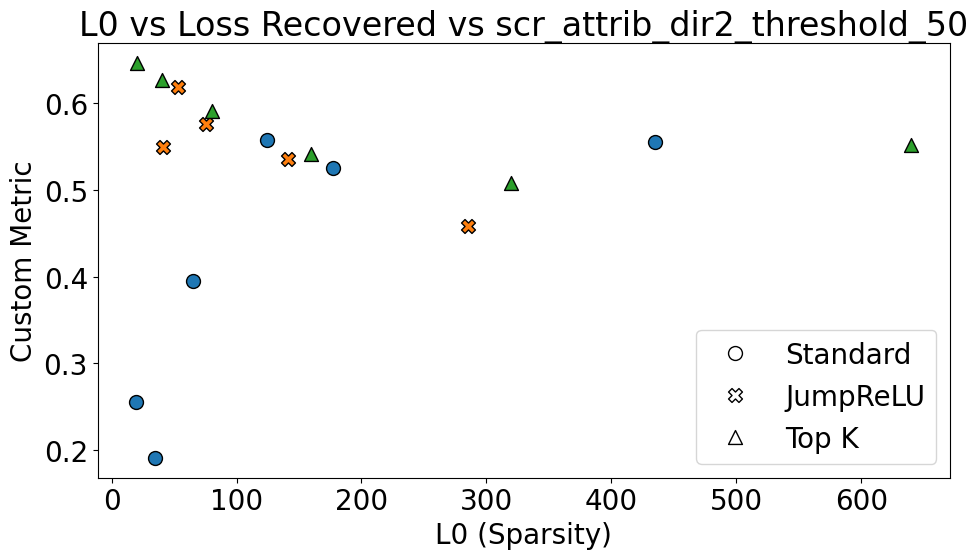

In [182]:
custom_metric = f"scr_bias_shift_dir1_threshold_{threshold}"
custom_metric = f"scr_attrib_dir2_threshold_{threshold}"

title = f"L0 vs Loss Recovered vs {custom_metric}"

plot_3var_graph(plotting_results, title, custom_metric)
plot_2var_graph(plotting_results, custom_metric, title=title, y_label="Custom Metric")
plot_interactive_3var_graph(plotting_results, custom_metric)

In [183]:
print(plotting_results[first_key].keys())

dict_keys(['trainer_class', 'l1_penalty', 'lr', 'dict_size', 'steps', 'l2_loss', 'l1_loss', 'l0', 'frac_variance_explained', 'cossim', 'l2_ratio', 'relative_reconstruction_bias', 'loss_original', 'loss_reconstructed', 'loss_zero', 'frac_recovered', 'frac_alive', 'hyperparameters', 'tpp_attrib_threshold_2_total_metric', 'tpp_attrib_threshold_2_intended_diff_only', 'tpp_attrib_threshold_2_unintended_diff_only', 'tpp_attrib_threshold_5_total_metric', 'tpp_attrib_threshold_5_intended_diff_only', 'tpp_attrib_threshold_5_unintended_diff_only', 'tpp_attrib_threshold_10_total_metric', 'tpp_attrib_threshold_10_intended_diff_only', 'tpp_attrib_threshold_10_unintended_diff_only', 'tpp_attrib_threshold_20_total_metric', 'tpp_attrib_threshold_20_intended_diff_only', 'tpp_attrib_threshold_20_unintended_diff_only', 'tpp_attrib_threshold_50_total_metric', 'tpp_attrib_threshold_50_intended_diff_only', 'tpp_attrib_threshold_50_unintended_diff_only', 'tpp_attrib_threshold_100_total_metric', 'tpp_attrib_t

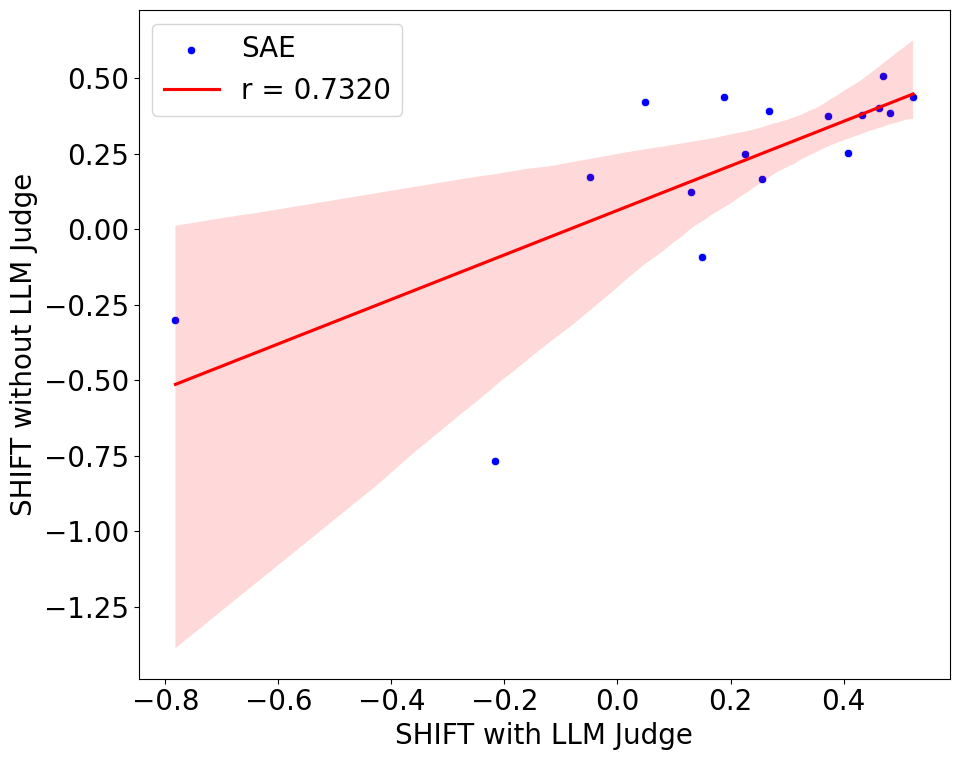

Pearson correlation coefficient (r): 0.7320
Coefficient of determination (r²): 0.5358
P-value: 0.0008


In [184]:
metric1 = f"scr_bias_shift_dir1_threshold_{threshold}"
metric2 = f"scr_attrib_dir1_threshold_{threshold}"
title = f"{metric1} vs {metric2}"
title = ""

output_filename = f"{image_filename_prefix}scr_comparison_{threshold}_{model_name}.png"

plot_metric_scatter(
    plotting_results,
    metric_x=metric1,
    metric_y=metric2,
    title=title,
    x_label="SHIFT with LLM Judge",
    y_label="SHIFT without LLM Judge",
    output_filename=output_filename,
)

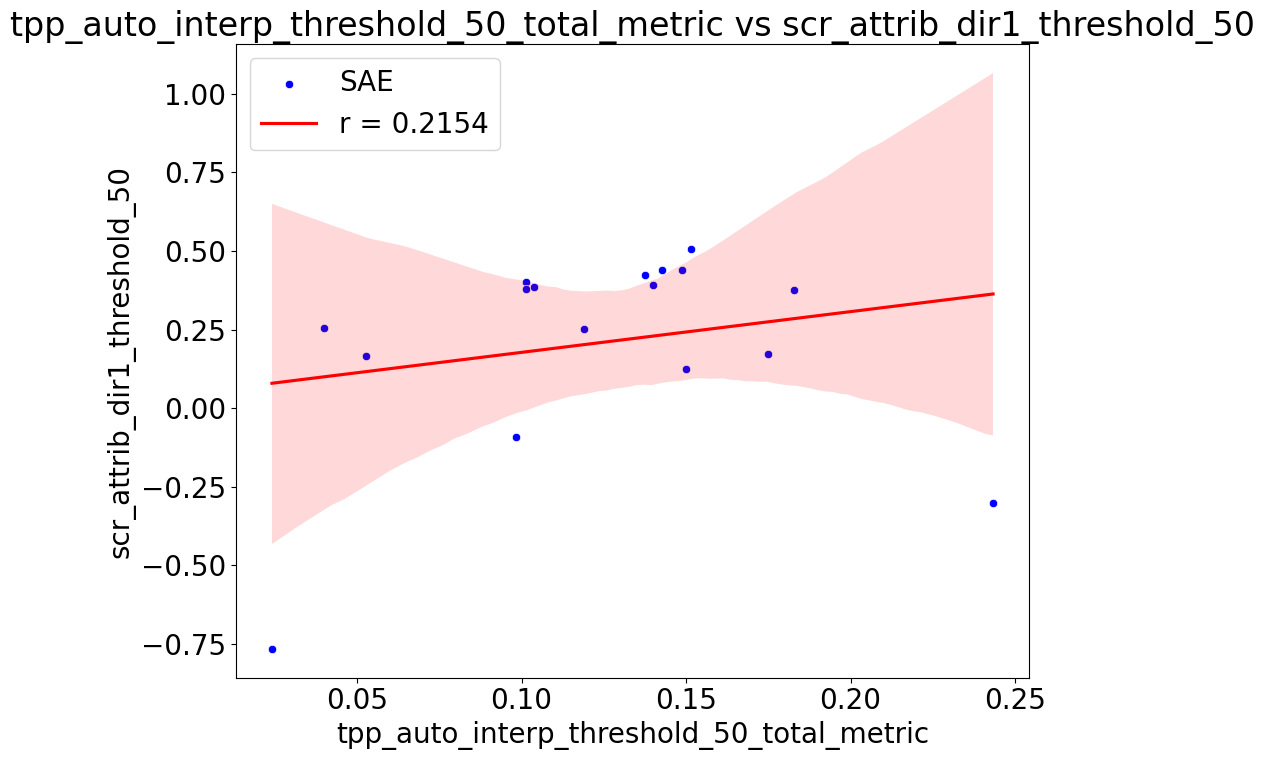

Pearson correlation coefficient (r): 0.2154
Coefficient of determination (r²): 0.0464
P-value: 0.4065


In [185]:
metric1 = f"tpp_auto_interp_threshold_{threshold}_total_metric"
metric2 = f"scr_attrib_dir1_threshold_{threshold}"
title = f"{metric1} vs {metric2}"
plot_metric_scatter(plotting_results, metric_x=metric1, metric_y=metric2, title=title)